In [5]:
"""
═══════════════════════════════════════════════════════════════════════
RDD2022 DATASET - COMPREHENSIVE EXPLORATORY DATA ANALYSIS
═══════════════════════════════════════════════════════════════════════
Dataset: Road Damage Detection 2022 (YOLO Format)
Total Images: ~38,416 (Train: 26,900 | Val: 5,758 | Test: 5,758)
Classes: 5 damage types
Format: YOLO (ready for training!)
═══════════════════════════════════════════════════════════════════════
"""

import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("RDD2022 EXPLORATORY DATA ANALYSIS")
print("="*70)

# Core imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from PIL import Image
import cv2
from tqdm.auto import tqdm
from pathlib import Path

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

print("\n✅ Libraries imported successfully!")
print("="*70 + "\n")

RDD2022 EXPLORATORY DATA ANALYSIS

✅ Libraries imported successfully!



In [6]:
"""
DATASET CONFIGURATION
Define paths and class names
"""

# Find the dataset path in Kaggle
print("📂 Searching for RDD2022 dataset...\n")

# Common Kaggle dataset locations
possible_paths = [
    Path("/kaggle/input/rdd2022"),
    Path("/kaggle/input/road-damage-detection-2022"),
    Path("/kaggle/input/rdd-2022"),
    Path("/kaggle/input/rdd2022-road-damage-detection"),
]

# Check what's available
print("Available datasets in /kaggle/input/:")
for item in Path("/kaggle/input/").iterdir():
    print(f"   - {item.name}")
    # Add to possible paths
    possible_paths.append(item)

print("\n" + "="*70)

# Find the correct path
DATASET_PATH = None
for path in possible_paths:
    if path.exists():
        # Check if it has the right structure
        if (path / "train").exists() or (path / "RDD_SPLIT" / "train").exists():
            DATASET_PATH = path
            break

if DATASET_PATH is None:
    raise FileNotFoundError("❌ Could not find RDD2022 dataset. Please add it to your notebook.")

# Handle RDD_SPLIT subdirectory if present
if (DATASET_PATH / "RDD_SPLIT").exists():
    DATASET_PATH = DATASET_PATH / "RDD_SPLIT"

print(f"✅ Dataset found: {DATASET_PATH}\n")

# Define splits
SPLITS = ['train', 'val', 'test']

# Verify structure
print("Dataset structure:")
for split in SPLITS:
    split_path = DATASET_PATH / split
    if split_path.exists():
        n_images = len(list((split_path / "images").glob("*.jpg"))) if (split_path / "images").exists() else 0
        n_labels = len(list((split_path / "labels").glob("*.txt"))) if (split_path / "labels").exists() else 0
        print(f"   ✅ {split:8s}: {n_images:6,} images, {n_labels:6,} labels")
    else:
        print(f"   ❌ {split:8s}: Not found")

# Class names (from dataset description)
CLASS_NAMES = [
    'longitudinal crack',
    'transverse crack', 
    'alligator crack',
    'other corruption',
    'Pothole'
]

print(f"\n🏷️  Damage Classes ({len(CLASS_NAMES)}):")
for i, name in enumerate(CLASS_NAMES):
    print(f"   {i}: {name}")

print("\n" + "="*70 + "\n")

📂 Searching for RDD2022 dataset...

Available datasets in /kaggle/input/:
   - rdd-2022

✅ Dataset found: /kaggle/input/rdd-2022/RDD_SPLIT

Dataset structure:
   ✅ train   : 26,869 images, 26,869 labels
   ✅ val     :  5,758 images,  5,758 labels
   ✅ test    :  5,758 images,  5,758 labels

🏷️  Damage Classes (5):
   0: longitudinal crack
   1: transverse crack
   2: alligator crack
   3: other corruption
   4: Pothole




In [7]:
"""
YOLO LABEL PARSER
Functions to parse YOLO format annotations
"""

def parse_yolo_label(label_path, img_width, img_height):
    """
    Parse YOLO format label file
    
    YOLO format: class_id center_x center_y width height (normalized 0-1)
    
    Returns: List of bounding boxes with class info
    """
    bboxes = []
    
    if not label_path.exists():
        return bboxes
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                try:
                    class_id = int(parts[0])
                    center_x = float(parts[1])
                    center_y = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    # Convert to absolute coordinates
                    abs_width = width * img_width
                    abs_height = height * img_height
                    abs_center_x = center_x * img_width
                    abs_center_y = center_y * img_height
                    
                    # Convert to corner coordinates
                    xmin = abs_center_x - (abs_width / 2)
                    ymin = abs_center_y - (abs_height / 2)
                    xmax = abs_center_x + (abs_width / 2)
                    ymax = abs_center_y + (abs_height / 2)
                    
                    bboxes.append({
                        'class_id': class_id,
                        'class_name': CLASS_NAMES[class_id] if class_id < len(CLASS_NAMES) else 'unknown',
                        'center_x': center_x,
                        'center_y': center_y,
                        'width': width,
                        'height': height,
                        'abs_width': abs_width,
                        'abs_height': abs_height,
                        'area': abs_width * abs_height,
                        'xmin': xmin,
                        'ymin': ymin,
                        'xmax': xmax,
                        'ymax': ymax
                    })
                except (ValueError, IndexError) as e:
                    continue
    
    return bboxes


def load_split_data(split_name):
    """Load all images and labels for a split"""
    split_path = DATASET_PATH / split_name
    images_path = split_path / "images"
    labels_path = split_path / "labels"
    
    data = []
    
    # Get all images
    image_files = sorted(images_path.glob("*.jpg"))
    
    for img_path in tqdm(image_files, desc=f"Loading {split_name}"):
        # Get corresponding label file
        label_path = labels_path / (img_path.stem + ".txt")
        
        # Get image dimensions
        try:
            img = Image.open(img_path)
            img_width, img_height = img.size
            img.close()
        except:
            continue
        
        # Parse labels
        bboxes = parse_yolo_label(label_path, img_width, img_height)
        
        data.append({
            'filename': img_path.name,
            'img_path': str(img_path),
            'label_path': str(label_path),
            'width': img_width,
            'height': img_height,
            'aspect_ratio': img_width / img_height,
            'n_objects': len(bboxes),
            'bboxes': bboxes
        })
    
    return data


print("✅ YOLO parser functions defined")
print("   - parse_yolo_label()")
print("   - load_split_data()")

✅ YOLO parser functions defined
   - parse_yolo_label()
   - load_split_data()


In [8]:
"""
LOAD ALL ANNOTATIONS
Parse YOLO labels from all splits
"""

all_data = {}
split_stats = []

print("📥 Loading YOLO Annotations...\n")
print("="*70 + "\n")

for split in SPLITS:
    split_path = DATASET_PATH / split
    
    if not split_path.exists():
        print(f"⚠️  Skipping {split} - directory not found")
        continue
    
    # Load data
    data = load_split_data(split)
    all_data[split] = data
    
    # Calculate stats
    n_images = len(data)
    n_annotations = sum(item['n_objects'] for item in data)
    
    split_stats.append({
        'split': split,
        'n_images': n_images,
        'n_annotations': n_annotations,
        'avg_annotations_per_image': n_annotations / n_images if n_images > 0 else 0
    })
    
    print(f"✅ {split:8s}: {n_images:6,} images, {n_annotations:8,} annotations")

# Create summary DataFrame
df_stats = pd.DataFrame(split_stats)

print("\n" + "="*70)
print("DATASET LOADING SUMMARY")
print("="*70 + "\n")
print(df_stats.to_string(index=False))

# Calculate totals
total_images = df_stats['n_images'].sum()
total_annotations = df_stats['n_annotations'].sum()

print("\n" + "="*70)
print("📊 TOTAL DATASET STATISTICS")
print("="*70)
print(f"Total Images:          {total_images:,}")
print(f"Total Annotations:     {total_annotations:,}")
print(f"Train Images:          {df_stats[df_stats['split']=='train']['n_images'].sum():,}")
print(f"Val Images:            {df_stats[df_stats['split']=='val']['n_images'].sum():,}")
print(f"Test Images:           {df_stats[df_stats['split']=='test']['n_images'].sum():,}")
print(f"Avg Annotations/Image: {total_annotations/total_images:.2f}")
print("="*70 + "\n")

📥 Loading YOLO Annotations...




Loading train:   0%|          | 0/26869 [00:00<?, ?it/s]

✅ train   : 26,869 images,   46,296 annotations


Loading val:   0%|          | 0/5758 [00:00<?, ?it/s]

✅ val     :  5,758 images,    9,741 annotations


Loading test:   0%|          | 0/5758 [00:00<?, ?it/s]

✅ test    :  5,758 images,    9,675 annotations

DATASET LOADING SUMMARY

split  n_images  n_annotations  avg_annotations_per_image
train     26869          46296                   1.723027
  val      5758           9741                   1.691733
 test      5758           9675                   1.680271

📊 TOTAL DATASET STATISTICS
Total Images:          38,385
Total Annotations:     65,712
Train Images:          26,869
Val Images:            5,758
Test Images:           5,758
Avg Annotations/Image: 1.71



In [9]:
"""
CLASS DISTRIBUTION ANALYSIS
Analyze damage type distribution
"""

print("📊 Analyzing Class Distribution...\n")

# Collect class distributions
class_counts_by_split = {}
overall_class_counts = Counter()

for split_name, data in all_data.items():
    class_counts = Counter()
    
    for item in data:
        for bbox in item['bboxes']:
            class_name = bbox['class_name']
            class_counts[class_name] += 1
            overall_class_counts[class_name] += 1
    
    class_counts_by_split[split_name] = class_counts

# Create DataFrame
class_dist_data = []
for split_name, counts in class_counts_by_split.items():
    total = sum(counts.values())
    for class_name in CLASS_NAMES:
        count = counts.get(class_name, 0)
        class_dist_data.append({
            'Split': split_name,
            'Class': class_name,
            'Count': count,
            'Percentage': (count / total * 100) if total > 0 else 0
        })

df_class_dist = pd.DataFrame(class_dist_data)

print("="*70)
print("CLASS DISTRIBUTION BY SPLIT")
print("="*70 + "\n")

# Pivot table
pivot_counts = df_class_dist.pivot_table(
    index='Split',
    columns='Class',
    values='Count',
    fill_value=0
).astype(int)

print(pivot_counts)

print("\n" + "="*70)
print("OVERALL CLASS DISTRIBUTION")
print("="*70)

total_anns = sum(overall_class_counts.values())
for class_name in CLASS_NAMES:
    count = overall_class_counts.get(class_name, 0)
    pct = (count / total_anns * 100) if total_anns > 0 else 0
    print(f"{class_name:25s}: {count:8,} ({pct:5.2f}%)")

print("-"*70)
print(f"{'TOTAL':25s}: {total_anns:8,}")
print("="*70 + "\n")

# Store for later use
overall_class_series = pd.Series(overall_class_counts)

📊 Analyzing Class Distribution...

CLASS DISTRIBUTION BY SPLIT

Class  Pothole  alligator crack  longitudinal crack  other corruption  \
Split                                                                   
test       951             1537                3925              1587   
train     4628             7527               18201              7554   
val        965             1553                3890              1564   

Class  transverse crack  
Split                    
test               1675  
train              8386  
val                1769  

OVERALL CLASS DISTRIBUTION
longitudinal crack       :   26,016 (39.59%)
transverse crack         :   11,830 (18.00%)
alligator crack          :   10,617 (16.16%)
other corruption         :   10,705 (16.29%)
Pothole                  :    6,544 ( 9.96%)
----------------------------------------------------------------------
TOTAL                    :   65,712



In [10]:
"""
IMAGE SIZE ANALYSIS
Analyze image dimensions
"""

print("📐 Analyzing Image Dimensions...\n")

# Collect image sizes
all_image_sizes = []

for split_name, data in all_data.items():
    for item in data:
        all_image_sizes.append({
            'split': split_name,
            'width': item['width'],
            'height': item['height'],
            'aspect_ratio': item['aspect_ratio']
        })

df_sizes = pd.DataFrame(all_image_sizes)

print("="*70)
print("IMAGE SIZE STATISTICS")
print("="*70 + "\n")

print(df_sizes[['width', 'height', 'aspect_ratio']].describe())

print("\n" + "="*70)
print("MOST COMMON IMAGE SIZES")
print("="*70)

size_combos = df_sizes.groupby(['width', 'height']).size().sort_values(ascending=False).head(10)
for (w, h), count in size_combos.items():
    pct = (count / len(df_sizes) * 100)
    print(f"{w:4.0f} x {h:4.0f}: {count:6,} images ({pct:5.2f}%)")

print("="*70 + "\n")

📐 Analyzing Image Dimensions...

IMAGE SIZE STATISTICS

              width        height  aspect_ratio
count  38385.000000  38385.000000  38385.000000
mean    1313.136434    926.854292      1.189561
std     1325.644658    581.268101      0.367699
min      512.000000    512.000000      1.000000
25%      600.000000    600.000000      1.000000
50%      640.000000    640.000000      1.000000
75%      720.000000    720.000000      1.000000
max     4040.000000   2044.000000      1.985258

MOST COMMON IMAGE SIZES
 600 x  600: 13,016 images (33.91%)
 720 x  720:  7,706 images (20.08%)
 640 x  640:  4,805 images (12.52%)
 512 x  512:  4,378 images (11.41%)
4040 x 2035:  4,342 images (11.31%)
3643 x 2041:  2,896 images ( 7.54%)
3650 x 2044:    923 images ( 2.40%)
1024 x 1024:    147 images ( 0.38%)
 540 x  540:    124 images ( 0.32%)
1080 x 1080:     48 images ( 0.13%)



In [11]:
"""
BOUNDING BOX ANALYSIS
Analyze annotation statistics
"""

print("📦 Analyzing Bounding Boxes...\n")

# Collect bbox data
all_bbox_data = []

for split_name, data in all_data.items():
    for item in data:
        for bbox in item['bboxes']:
            all_bbox_data.append({
                'split': split_name,
                'class': bbox['class_name'],
                'width': bbox['abs_width'],
                'height': bbox['abs_height'],
                'area': bbox['area'],
                'center_x': bbox['center_x'],
                'center_y': bbox['center_y'],
                'normalized_width': bbox['width'],
                'normalized_height': bbox['height']
            })

df_bboxes = pd.DataFrame(all_bbox_data)

print("="*70)
print("BOUNDING BOX STATISTICS")
print("="*70 + "\n")

print(df_bboxes[['width', 'height', 'area']].describe())

# Size categories
def categorize_bbox_size(area):
    if area < 1000:
        return 'Small'
    elif area < 10000:
        return 'Medium'
    else:
        return 'Large'

df_bboxes['size_category'] = df_bboxes['area'].apply(categorize_bbox_size)

print("\n" + "="*70)
print("BOUNDING BOX SIZE CATEGORIES")
print("="*70)

for category in ['Small', 'Medium', 'Large']:
    count = (df_bboxes['size_category'] == category).sum()
    pct = (count / len(df_bboxes) * 100)
    print(f"{category:10s} (<1K / 1K-10K / >10K px²): {count:8,} ({pct:5.2f}%)")

# Class-wise stats
print("\n" + "="*70)
print("CLASS-WISE BOUNDING BOX STATISTICS")
print("="*70 + "\n")

class_bbox_stats = df_bboxes.groupby('class').agg({
    'width': ['mean', 'median', 'std'],
    'height': ['mean', 'median', 'std'],
    'area': ['mean', 'median', 'std']
}).round(2)

print(class_bbox_stats)
print("\n" + "="*70 + "\n")

📦 Analyzing Bounding Boxes...

BOUNDING BOX STATISTICS

              width        height          area
count  65712.000000  65712.000000  6.571200e+04
mean     165.876461    121.283465  2.692456e+04
std      182.769001    114.977810  5.533654e+04
min        0.000000      1.000200  0.000000e+00
25%       58.408219     38.999680  2.960000e+03
50%      110.000160     87.000000  8.651182e+03
75%      204.000000    167.999760  2.767803e+04
max     2375.108495   1104.999441  1.005171e+06

BOUNDING BOX SIZE CATEGORIES
Small      (<1K / 1K-10K / >10K px²):    5,030 ( 7.65%)
Medium     (<1K / 1K-10K / >10K px²):   30,043 (45.72%)
Large      (<1K / 1K-10K / >10K px²):   30,639 (46.63%)

CLASS-WISE BOUNDING BOX STATISTICS

                     width                 height                     area  \
                      mean median     std    mean median     std      mean   
class                                                                        
Pothole              95.31   67.0   85.31  

In [12]:
"""
ANNOTATIONS PER IMAGE ANALYSIS
"""

print("="*70)
print("ANNOTATIONS PER IMAGE STATISTICS")
print("="*70 + "\n")

# Collect annotations per image
ann_per_image_data = []

for split_name, data in all_data.items():
    for item in data:
        ann_per_image_data.append({
            'split': split_name,
            'n_annotations': item['n_objects']
        })

df_ann_per_img = pd.DataFrame(ann_per_image_data)

print(df_ann_per_img['n_annotations'].describe())

print("\n" + "="*70)
print("DISTRIBUTION OF ANNOTATIONS PER IMAGE")
print("="*70)

ann_dist = df_ann_per_img['n_annotations'].value_counts().sort_index()

for n_ann, count in ann_dist.head(15).items():
    pct = (count / len(df_ann_per_img) * 100)
    bar = '█' * int(pct / 2)
    print(f"{n_ann:2d} annotations: {count:6,} images ({pct:5.2f}%) {bar}")

if len(ann_dist) > 15:
    print(f"... and images with {ann_dist.index[15]}-{ann_dist.index[-1]} annotations")

print("="*70 + "\n")

ANNOTATIONS PER IMAGE STATISTICS

count    38385.000000
mean         1.711919
std          2.054314
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         44.000000
Name: n_annotations, dtype: float64

DISTRIBUTION OF ANNOTATIONS PER IMAGE
 0 annotations: 11,724 images (30.54%) ███████████████
 1 annotations: 10,218 images (26.62%) █████████████
 2 annotations:  7,090 images (18.47%) █████████
 3 annotations:  4,151 images (10.81%) █████
 4 annotations:  2,338 images ( 6.09%) ███
 5 annotations:  1,235 images ( 3.22%) █
 6 annotations:    671 images ( 1.75%) 
 7 annotations:    344 images ( 0.90%) 
 8 annotations:    184 images ( 0.48%) 
 9 annotations:    104 images ( 0.27%) 
10 annotations:     81 images ( 0.21%) 
11 annotations:     50 images ( 0.13%) 
12 annotations:     41 images ( 0.11%) 
13 annotations:     30 images ( 0.08%) 
14 annotations:     30 images ( 0.08%) 
... and images with 15-44 annotations



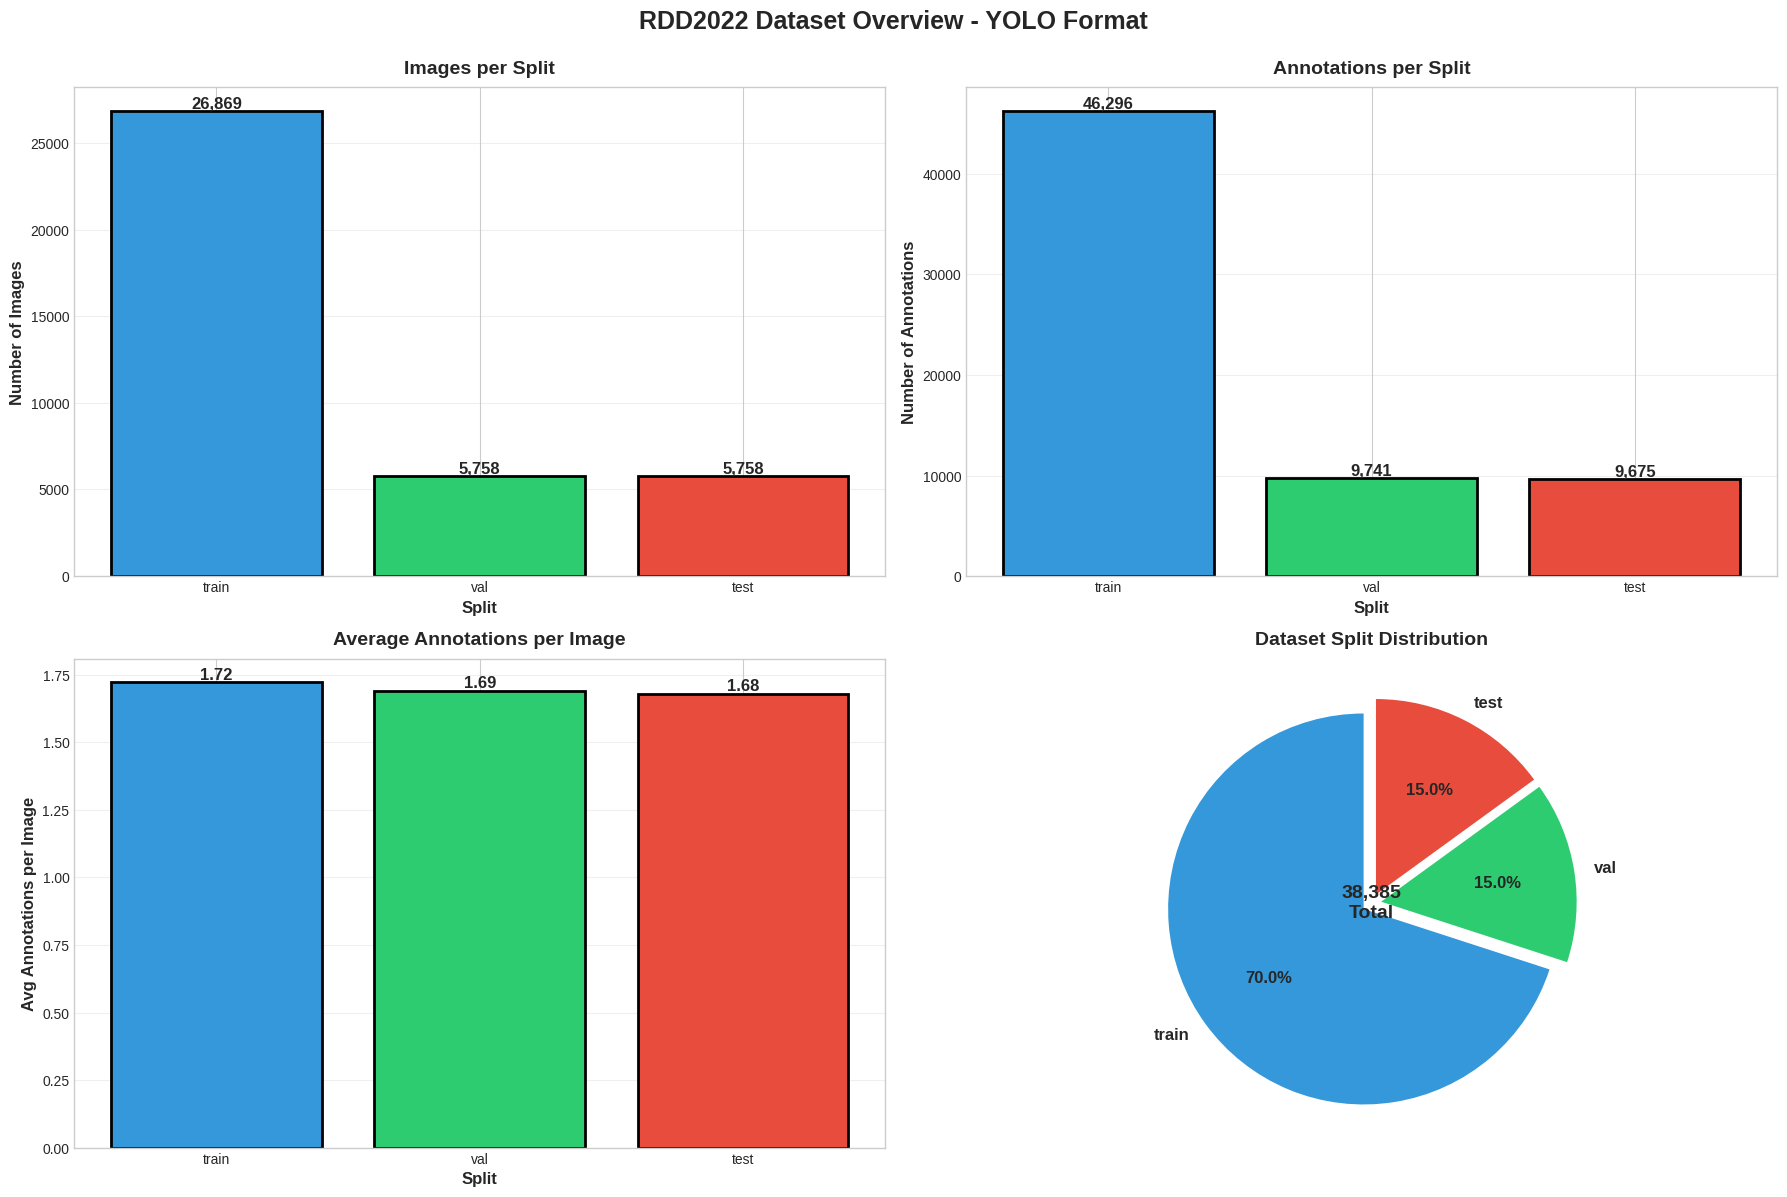

✅ Dataset overview visualization complete


In [13]:
"""
VISUALIZATION 1: Dataset Overview
"""

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('RDD2022 Dataset Overview - YOLO Format', fontsize=18, fontweight='bold', y=0.995)

# 1. Images per split
ax1 = axes[0, 0]
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax1.bar(df_stats['split'], df_stats['n_images'], color=colors, edgecolor='black', linewidth=2)
ax1.set_xlabel('Split', fontweight='bold')
ax1.set_ylabel('Number of Images', fontweight='bold')
ax1.set_title('Images per Split', fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, df_stats['n_images']):
    ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 2. Annotations per split
ax2 = axes[0, 1]
bars = ax2.bar(df_stats['split'], df_stats['n_annotations'], color=colors, edgecolor='black', linewidth=2)
ax2.set_xlabel('Split', fontweight='bold')
ax2.set_ylabel('Number of Annotations', fontweight='bold')
ax2.set_title('Annotations per Split', fontweight='bold', pad=10)
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, df_stats['n_annotations']):
    ax2.text(bar.get_x() + bar.get_width()/2, val, f'{val:,}', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 3. Average annotations per image
ax3 = axes[1, 0]
bars = ax3.bar(df_stats['split'], df_stats['avg_annotations_per_image'], color=colors, edgecolor='black', linewidth=2)
ax3.set_xlabel('Split', fontweight='bold')
ax3.set_ylabel('Avg Annotations per Image', fontweight='bold')
ax3.set_title('Average Annotations per Image', fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, df_stats['avg_annotations_per_image']):
    ax3.text(bar.get_x() + bar.get_width()/2, val, f'{val:.2f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)

# 4. Split distribution pie
ax4 = axes[1, 1]
wedges, texts, autotexts = ax4.pie(df_stats['n_images'], labels=df_stats['split'],
                                     autopct='%1.1f%%', startangle=90, colors=colors,
                                     textprops={'fontsize': 12, 'fontweight': 'bold'},
                                     explode=[0.05, 0.05, 0.05])
ax4.set_title('Dataset Split Distribution', fontweight='bold', pad=10)

total = df_stats['n_images'].sum()
ax4.text(0, 0, f'{total:,}\nTotal', ha='center', va='center',
         fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Dataset overview visualization complete")

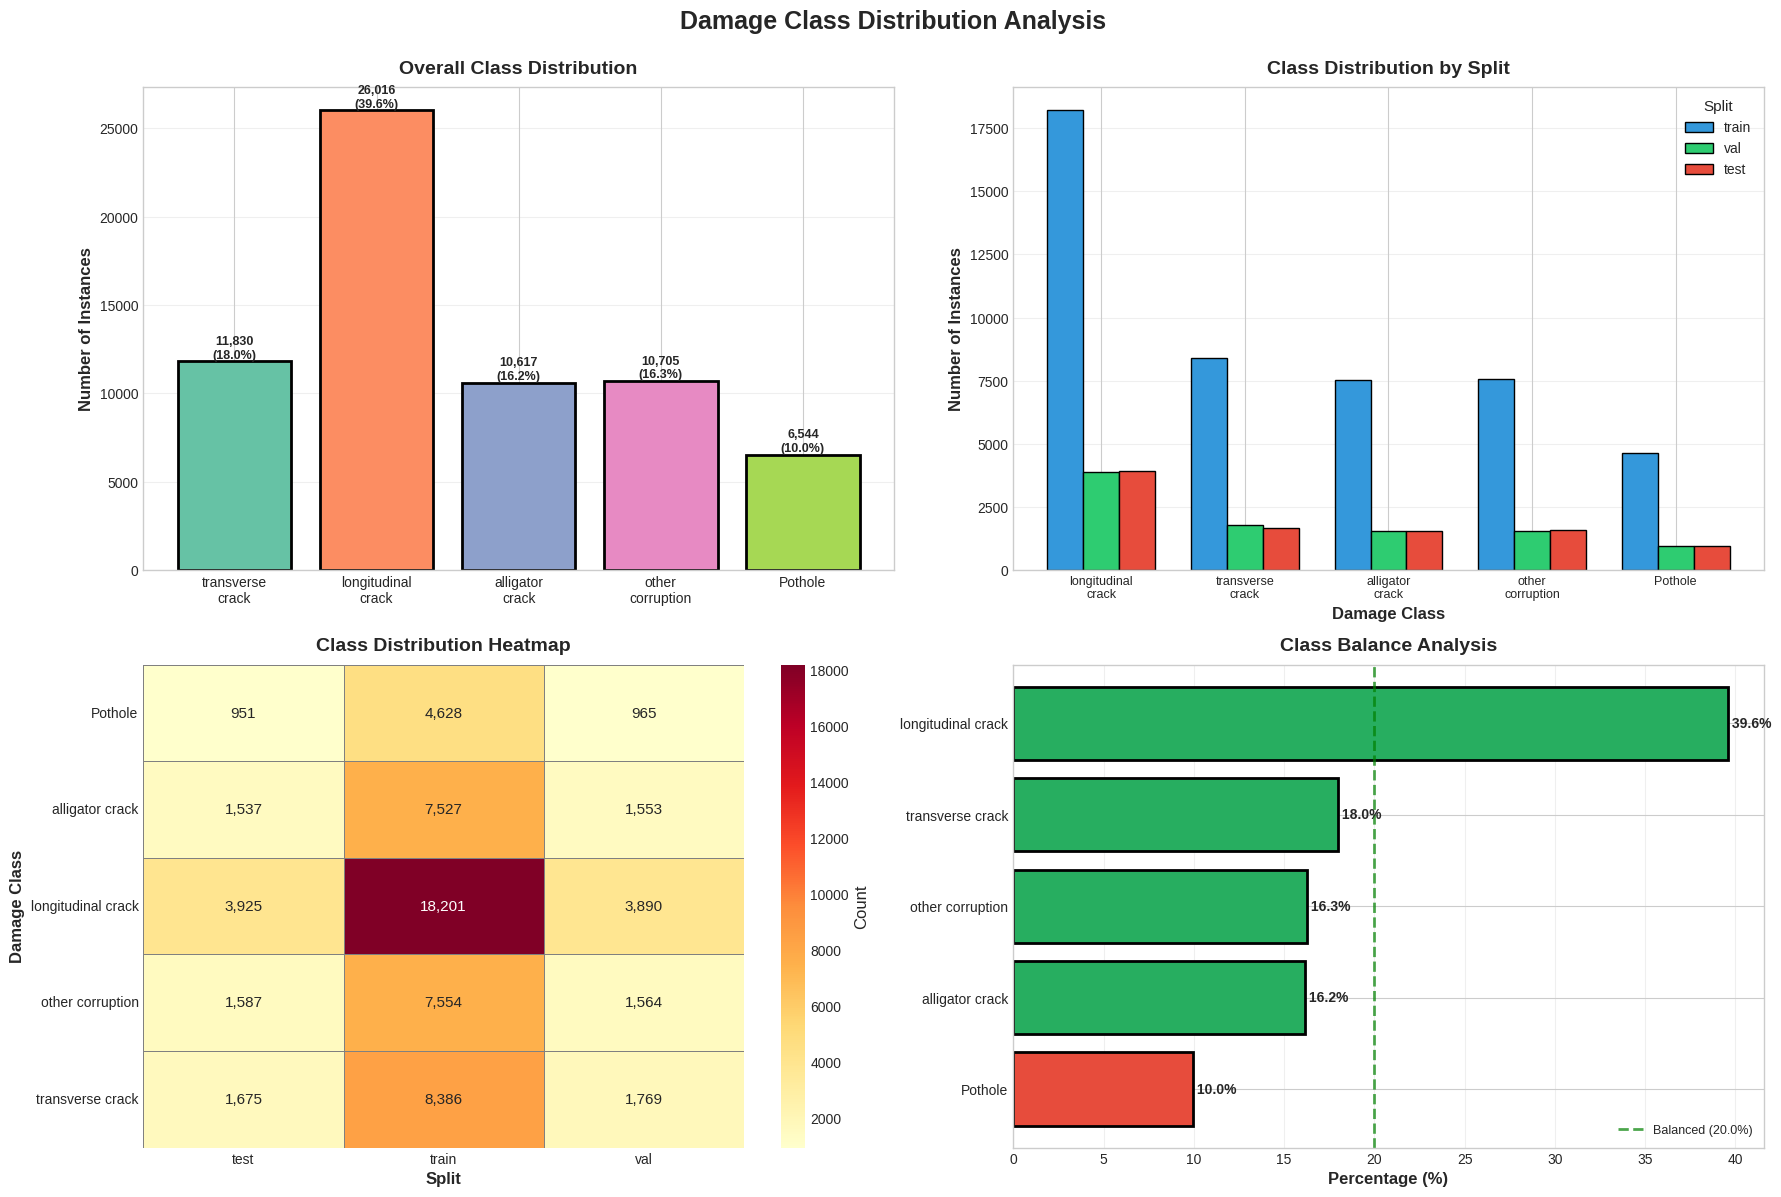

✅ Class distribution visualization complete


In [14]:
"""
VISUALIZATION 2: Class Distribution Analysis
"""

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Damage Class Distribution Analysis', fontsize=18, fontweight='bold', y=0.995)

# 1. Overall class distribution
ax1 = axes[0, 0]
class_colors = sns.color_palette("Set2", len(CLASS_NAMES))
bars = ax1.bar(range(len(overall_class_series)), overall_class_series.values, 
               color=class_colors, edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(overall_class_series)))
ax1.set_xticklabels([name.replace(' ', '\n') for name in overall_class_series.index], fontsize=10)
ax1.set_ylabel('Number of Instances', fontweight='bold')
ax1.set_title('Overall Class Distribution', fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)

# Add labels
for i, (bar, val) in enumerate(zip(bars, overall_class_series.values)):
    pct = (val / overall_class_series.sum() * 100)
    ax1.text(i, val, f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Class distribution by split (grouped bar)
ax2 = axes[0, 1]
x = np.arange(len(CLASS_NAMES))
width = 0.25

for i, split in enumerate(SPLITS):
    split_counts = [class_counts_by_split[split].get(cls, 0) for cls in CLASS_NAMES]
    offset = (i - 1) * width
    ax2.bar(x + offset, split_counts, width, label=split, 
            color=['#3498db', '#2ecc71', '#e74c3c'][i], edgecolor='black', linewidth=1)

ax2.set_xlabel('Damage Class', fontweight='bold')
ax2.set_ylabel('Number of Instances', fontweight='bold')
ax2.set_title('Class Distribution by Split', fontweight='bold', pad=10)
ax2.set_xticks(x)
ax2.set_xticklabels([name.replace(' ', '\n') for name in CLASS_NAMES], fontsize=9)
ax2.legend(title='Split', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# 3. Class distribution heatmap
ax3 = axes[1, 0]
heatmap_data = pivot_counts.T
sns.heatmap(heatmap_data, annot=True, fmt=',', cmap='YlOrRd', ax=ax3,
            cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
ax3.set_xlabel('Split', fontweight='bold')
ax3.set_ylabel('Damage Class', fontweight='bold')
ax3.set_title('Class Distribution Heatmap', fontweight='bold', pad=10)
ax3.set_yticklabels(ax3.get_yticklabels(), rotation=0)

# 4. Class balance (percentage)
ax4 = axes[1, 1]
class_percentages = (overall_class_series / overall_class_series.sum() * 100).sort_values(ascending=True)
expected_balanced = 100 / len(CLASS_NAMES)

colors_balance = ['#27ae60' if p > expected_balanced * 0.8 else '#f39c12' if p > expected_balanced * 0.5 else '#e74c3c' 
                  for p in class_percentages]
bars = ax4.barh(range(len(class_percentages)), class_percentages.values, 
                color=colors_balance, edgecolor='black', linewidth=2)
ax4.set_yticks(range(len(class_percentages)))
ax4.set_yticklabels(class_percentages.index)
ax4.set_xlabel('Percentage (%)', fontweight='bold')
ax4.set_title('Class Balance Analysis', fontweight='bold', pad=10)
ax4.axvline(x=expected_balanced, color='green', linestyle='--', alpha=0.7, linewidth=2, 
            label=f'Balanced ({expected_balanced:.1f}%)')
ax4.grid(axis='x', alpha=0.3)
ax4.legend(fontsize=9)

for i, (bar, val) in enumerate(zip(bars, class_percentages.values)):
    ax4.text(val, i, f' {val:.1f}%', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Class distribution visualization complete")

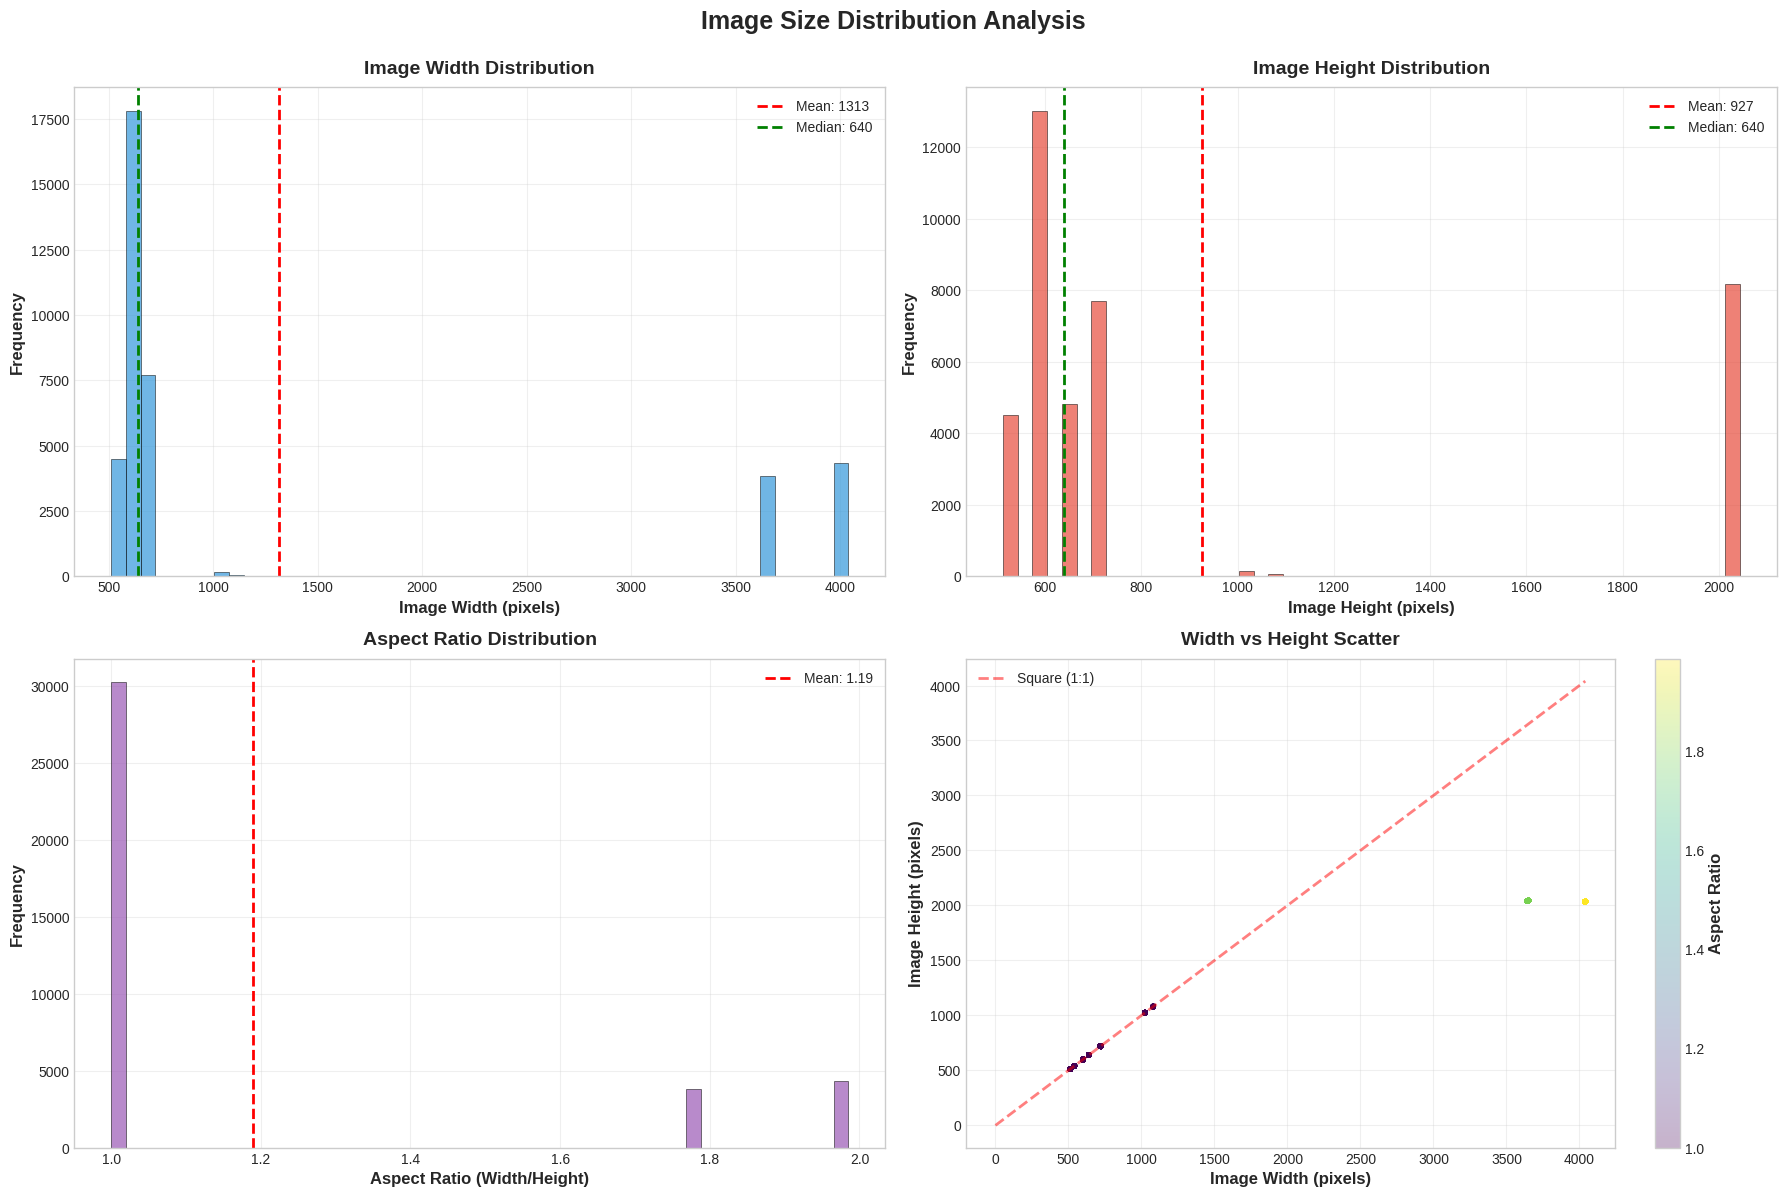

✅ Image size visualization complete


In [15]:
"""
VISUALIZATION 3: Image Size Distribution
"""

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Image Size Distribution Analysis', fontsize=18, fontweight='bold', y=0.995)

# 1. Width distribution
ax1 = axes[0, 0]
ax1.hist(df_sizes['width'], bins=50, alpha=0.7, color='#3498db', edgecolor='black', linewidth=0.5)
ax1.axvline(df_sizes['width'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {df_sizes["width"].mean():.0f}')
ax1.axvline(df_sizes['width'].median(), color='green', linestyle='--', linewidth=2, 
            label=f'Median: {df_sizes["width"].median():.0f}')
ax1.set_xlabel('Image Width (pixels)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Image Width Distribution', fontweight='bold', pad=10)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# 2. Height distribution
ax2 = axes[0, 1]
ax2.hist(df_sizes['height'], bins=50, alpha=0.7, color='#e74c3c', edgecolor='black', linewidth=0.5)
ax2.axvline(df_sizes['height'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {df_sizes["height"].mean():.0f}')
ax2.axvline(df_sizes['height'].median(), color='green', linestyle='--', linewidth=2, 
            label=f'Median: {df_sizes["height"].median():.0f}')
ax2.set_xlabel('Image Height (pixels)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Image Height Distribution', fontweight='bold', pad=10)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# 3. Aspect ratio distribution
ax3 = axes[1, 0]
ax3.hist(df_sizes['aspect_ratio'], bins=50, alpha=0.7, color='#9b59b6', edgecolor='black', linewidth=0.5)
ax3.axvline(df_sizes['aspect_ratio'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {df_sizes["aspect_ratio"].mean():.2f}')
ax3.set_xlabel('Aspect Ratio (Width/Height)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Aspect Ratio Distribution', fontweight='bold', pad=10)
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# 4. Width vs Height scatter
ax4 = axes[1, 1]
scatter = ax4.scatter(df_sizes['width'], df_sizes['height'], 
                     alpha=0.3, s=10, c=df_sizes['aspect_ratio'], cmap='viridis')
ax4.set_xlabel('Image Width (pixels)', fontweight='bold')
ax4.set_ylabel('Image Height (pixels)', fontweight='bold')
ax4.set_title('Width vs Height Scatter', fontweight='bold', pad=10)
ax4.grid(alpha=0.3)

max_val = max(df_sizes['width'].max(), df_sizes['height'].max())
ax4.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, linewidth=2, label='Square (1:1)')
ax4.legend(fontsize=10)

cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Aspect Ratio', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Image size visualization complete")

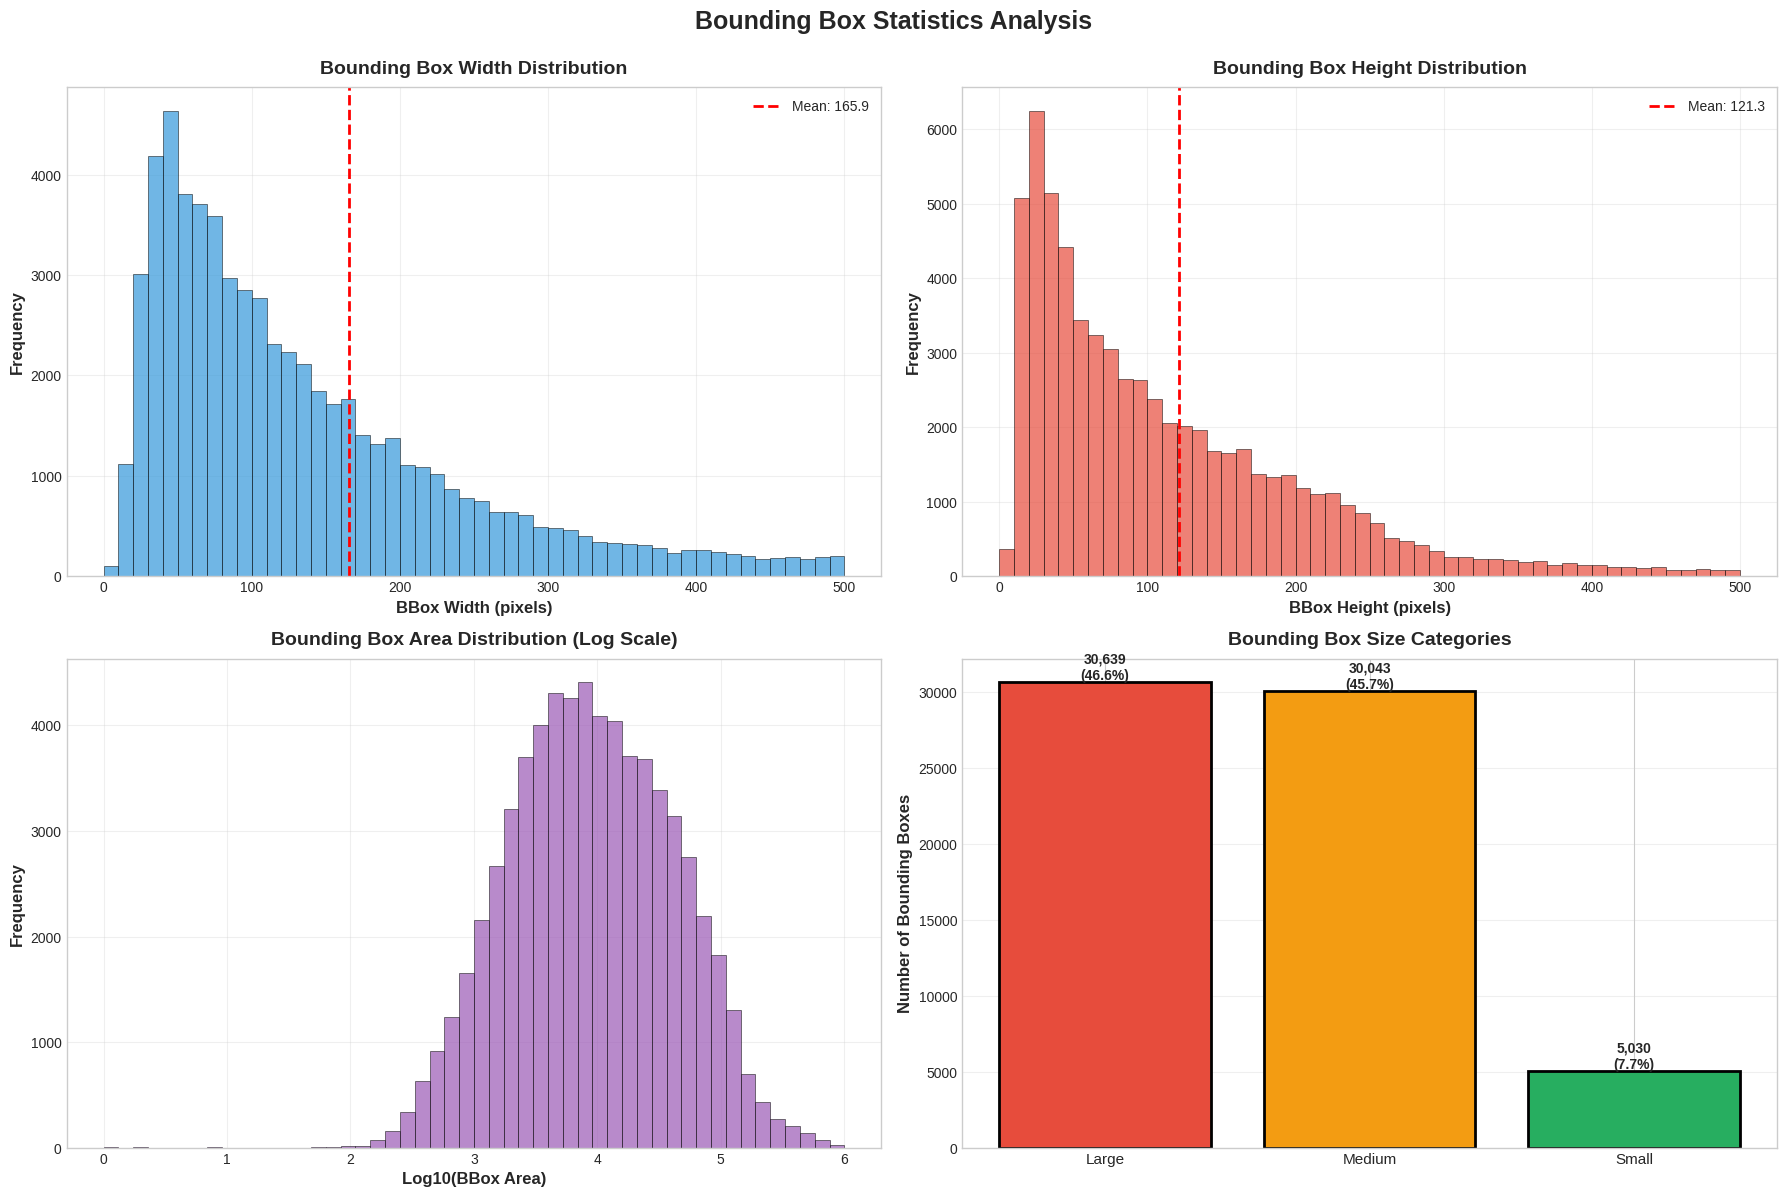

✅ Bounding box visualization complete


In [16]:
"""
VISUALIZATION 4: Bounding Box Statistics
"""

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Bounding Box Statistics Analysis', fontsize=18, fontweight='bold', y=0.995)

# 1. BBox width distribution
ax1 = axes[0, 0]
ax1.hist(df_bboxes['width'], bins=50, alpha=0.7, color='#3498db', 
         edgecolor='black', linewidth=0.5, range=(0, 500))
ax1.axvline(df_bboxes['width'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {df_bboxes["width"].mean():.1f}')
ax1.set_xlabel('BBox Width (pixels)', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Bounding Box Width Distribution', fontweight='bold', pad=10)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# 2. BBox height distribution
ax2 = axes[0, 1]
ax2.hist(df_bboxes['height'], bins=50, alpha=0.7, color='#e74c3c', 
         edgecolor='black', linewidth=0.5, range=(0, 500))
ax2.axvline(df_bboxes['height'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {df_bboxes["height"].mean():.1f}')
ax2.set_xlabel('BBox Height (pixels)', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Bounding Box Height Distribution', fontweight='bold', pad=10)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# 3. BBox area distribution (log scale)
ax3 = axes[1, 0]
ax3.hist(np.log10(df_bboxes['area'] + 1), bins=50, alpha=0.7, color='#9b59b6', 
         edgecolor='black', linewidth=0.5)
ax3.set_xlabel('Log10(BBox Area)', fontweight='bold')
ax3.set_ylabel('Frequency', fontweight='bold')
ax3.set_title('Bounding Box Area Distribution (Log Scale)', fontweight='bold', pad=10)
ax3.grid(alpha=0.3)

# 4. Size categories
ax4 = axes[1, 1]
size_cats = df_bboxes['size_category'].value_counts()
colors_cat = ['#e74c3c', '#f39c12', '#27ae60']
bars = ax4.bar(range(len(size_cats)), size_cats.values, color=colors_cat, 
               edgecolor='black', linewidth=2)
ax4.set_xticks(range(len(size_cats)))
ax4.set_xticklabels(size_cats.index, fontsize=11)
ax4.set_ylabel('Number of Bounding Boxes', fontweight='bold')
ax4.set_title('Bounding Box Size Categories', fontweight='bold', pad=10)
ax4.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, size_cats.values)):
    pct = (val / size_cats.sum() * 100)
    ax4.text(i, val, f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("✅ Bounding box visualization complete")

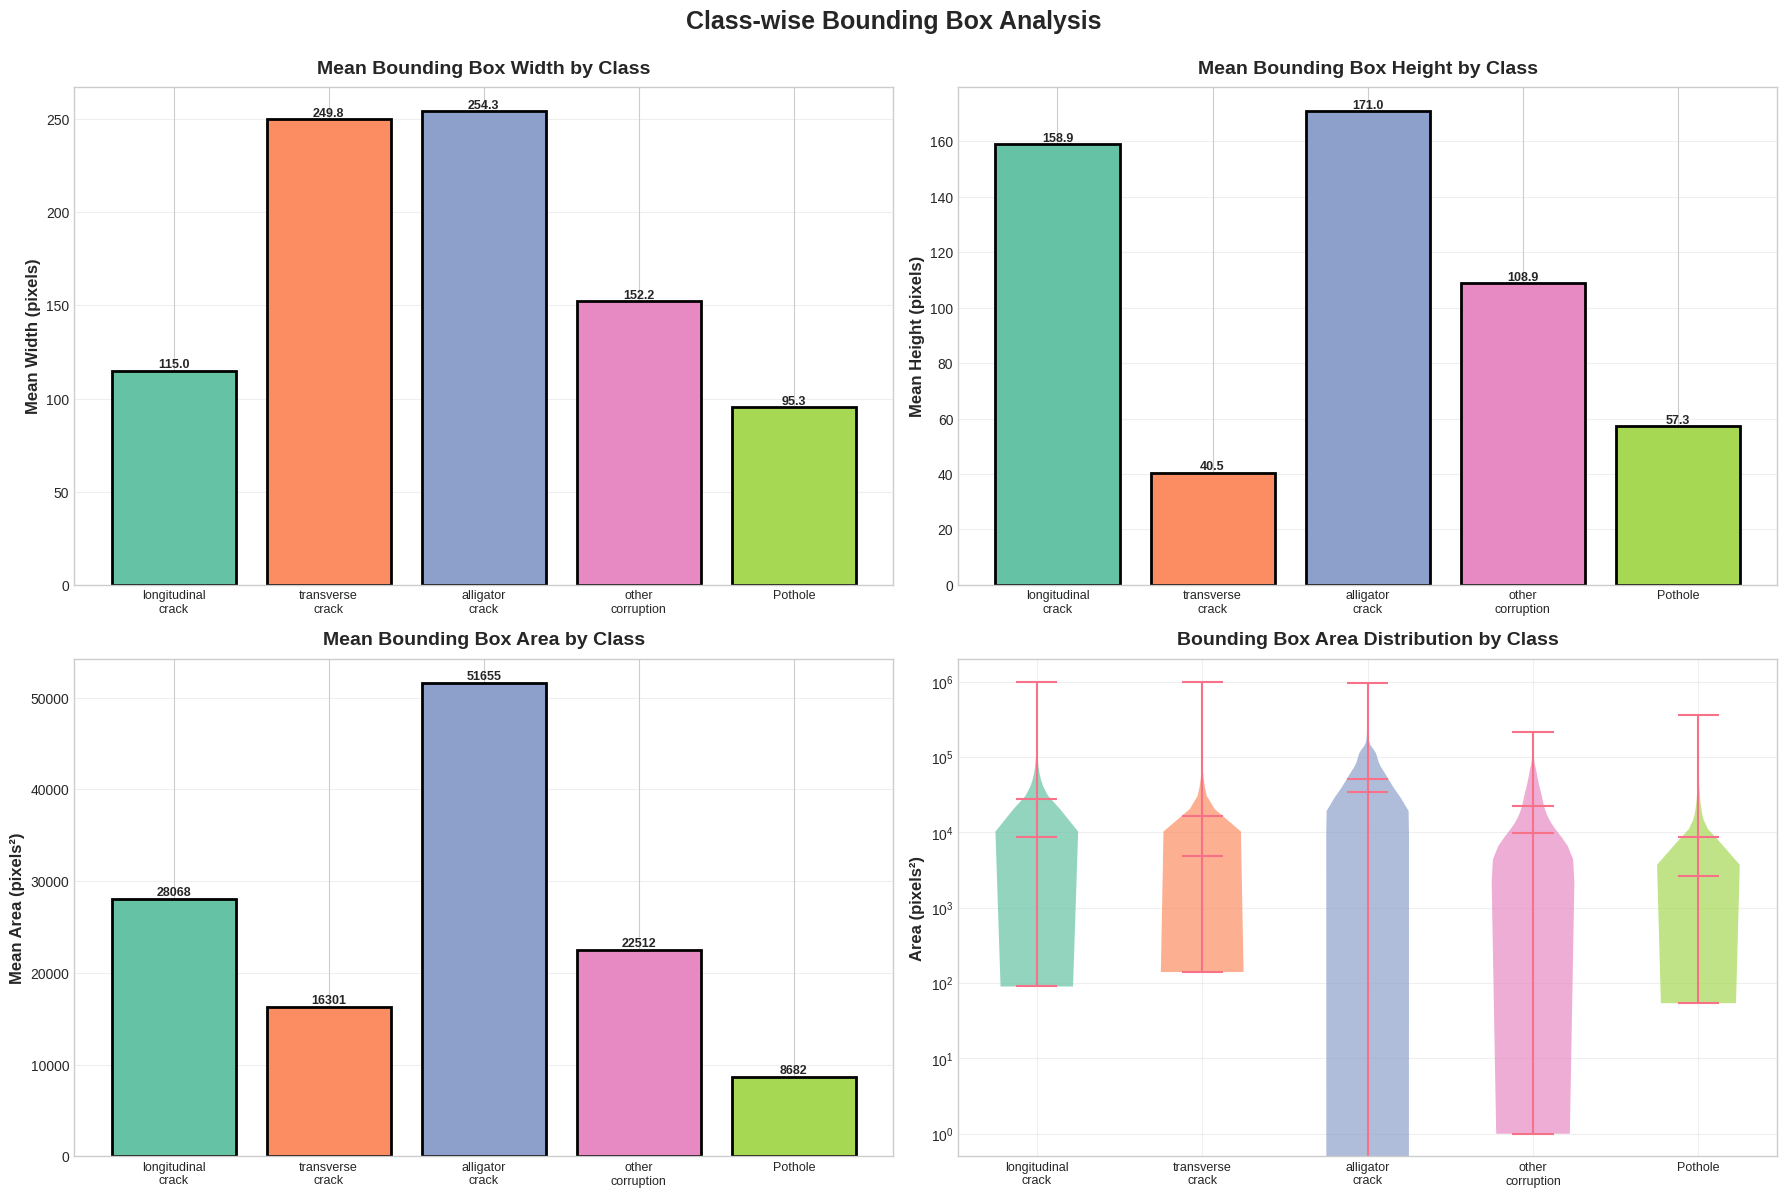

✅ Class-wise bbox visualization complete


In [17]:
"""
VISUALIZATION 5: Class-wise Bounding Box Analysis
"""

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Class-wise Bounding Box Analysis', fontsize=18, fontweight='bold', y=0.995)

class_groups = df_bboxes.groupby('class')
colors_class = sns.color_palette("Set2", len(CLASS_NAMES))

# 1. Mean bbox width by class
ax1 = axes[0, 0]
mean_widths = [class_groups.get_group(c)['width'].mean() if c in class_groups.groups else 0 
               for c in CLASS_NAMES]
bars = ax1.bar(range(len(CLASS_NAMES)), mean_widths, color=colors_class, 
               edgecolor='black', linewidth=2)
ax1.set_xticks(range(len(CLASS_NAMES)))
ax1.set_xticklabels([name.replace(' ', '\n') for name in CLASS_NAMES], rotation=0, ha='center', fontsize=9)
ax1.set_ylabel('Mean Width (pixels)', fontweight='bold')
ax1.set_title('Mean Bounding Box Width by Class', fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)

for i, val in enumerate(mean_widths):
    if val > 0:
        ax1.text(i, val, f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 2. Mean bbox height by class
ax2 = axes[0, 1]
mean_heights = [class_groups.get_group(c)['height'].mean() if c in class_groups.groups else 0 
                for c in CLASS_NAMES]
bars = ax2.bar(range(len(CLASS_NAMES)), mean_heights, color=colors_class, 
               edgecolor='black', linewidth=2)
ax2.set_xticks(range(len(CLASS_NAMES)))
ax2.set_xticklabels([name.replace(' ', '\n') for name in CLASS_NAMES], rotation=0, ha='center', fontsize=9)
ax2.set_ylabel('Mean Height (pixels)', fontweight='bold')
ax2.set_title('Mean Bounding Box Height by Class', fontweight='bold', pad=10)
ax2.grid(axis='y', alpha=0.3)

for i, val in enumerate(mean_heights):
    if val > 0:
        ax2.text(i, val, f'{val:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. Mean bbox area by class
ax3 = axes[1, 0]
mean_areas = [class_groups.get_group(c)['area'].mean() if c in class_groups.groups else 0 
              for c in CLASS_NAMES]
bars = ax3.bar(range(len(CLASS_NAMES)), mean_areas, color=colors_class, 
               edgecolor='black', linewidth=2)
ax3.set_xticks(range(len(CLASS_NAMES)))
ax3.set_xticklabels([name.replace(' ', '\n') for name in CLASS_NAMES], rotation=0, ha='center', fontsize=9)
ax3.set_ylabel('Mean Area (pixels²)', fontweight='bold')
ax3.set_title('Mean Bounding Box Area by Class', fontweight='bold', pad=10)
ax3.grid(axis='y', alpha=0.3)

for i, val in enumerate(mean_areas):
    if val > 0:
        ax3.text(i, val, f'{val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Bbox area distribution by class (violin plot)
ax4 = axes[1, 1]
areas_by_class = [class_groups.get_group(c)['area'].values if c in class_groups.groups else [0] 
                  for c in CLASS_NAMES]
parts = ax4.violinplot(areas_by_class, positions=range(len(CLASS_NAMES)), 
                       showmeans=True, showmedians=True)

for pc, color in zip(parts['bodies'], colors_class):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax4.set_xticks(range(len(CLASS_NAMES)))
ax4.set_xticklabels([name.replace(' ', '\n') for name in CLASS_NAMES], rotation=0, ha='center', fontsize=9)
ax4.set_ylabel('Area (pixels²)', fontweight='bold')
ax4.set_title('Bounding Box Area Distribution by Class', fontweight='bold', pad=10)
ax4.set_yscale('log')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Class-wise bbox visualization complete")

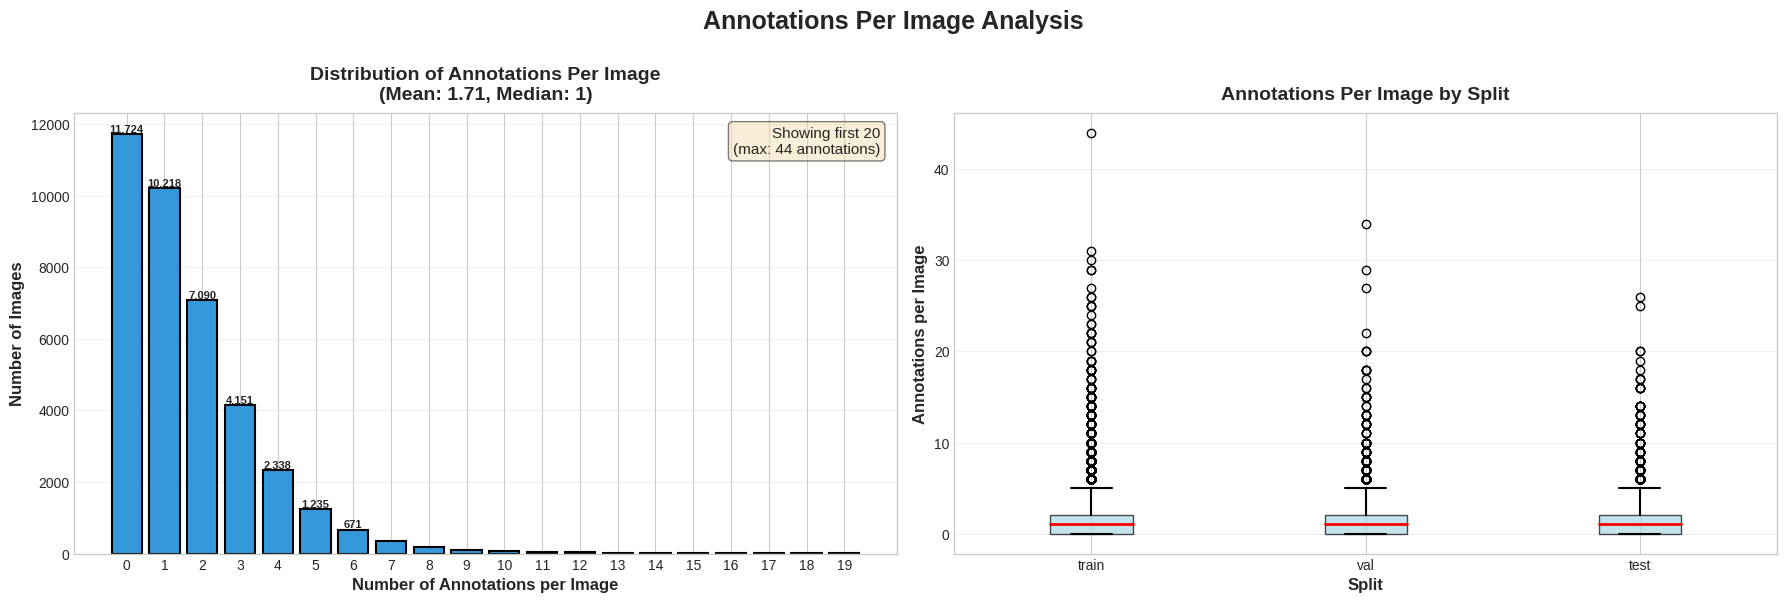

✅ Annotations per image visualization complete


In [18]:
"""
VISUALIZATION 6: Annotations Per Image Distribution
"""

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Annotations Per Image Analysis', fontsize=18, fontweight='bold', y=1.00)

# 1. Distribution histogram
ax1 = axes[0]
ann_counts = df_ann_per_img['n_annotations'].value_counts().sort_index()
ann_counts_display = ann_counts.head(20)

bars = ax1.bar(range(len(ann_counts_display)), ann_counts_display.values, 
               color='#3498db', edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(ann_counts_display)))
ax1.set_xticklabels(ann_counts_display.index, fontsize=10)
ax1.set_xlabel('Number of Annotations per Image', fontweight='bold')
ax1.set_ylabel('Number of Images', fontweight='bold')
ax1.set_title(f'Distribution of Annotations Per Image\n(Mean: {df_ann_per_img["n_annotations"].mean():.2f}, Median: {df_ann_per_img["n_annotations"].median():.0f})', 
              fontweight='bold', pad=10)
ax1.grid(axis='y', alpha=0.3)

for i, val in enumerate(ann_counts_display.values):
    if val > ann_counts_display.max() * 0.05:
        ax1.text(i, val, f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)

if len(ann_counts) > 20:
    ax1.text(0.98, 0.97, f'Showing first 20\n(max: {ann_counts.index.max()} annotations)', 
            transform=ax1.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Box plot by split
ax2 = axes[1]
splits_sorted = ['train', 'val', 'test']
data_by_split = [df_ann_per_img[df_ann_per_img['split'] == s]['n_annotations'].values 
                 for s in splits_sorted if s in df_ann_per_img['split'].values]

bp = ax2.boxplot(data_by_split, labels=splits_sorted[:len(data_by_split)], patch_artist=True,
                 medianprops=dict(color='red', linewidth=2),
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

ax2.set_xlabel('Split', fontweight='bold')
ax2.set_ylabel('Annotations per Image', fontweight='bold')
ax2.set_title('Annotations Per Image by Split', fontweight='bold', pad=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Annotations per image visualization complete")

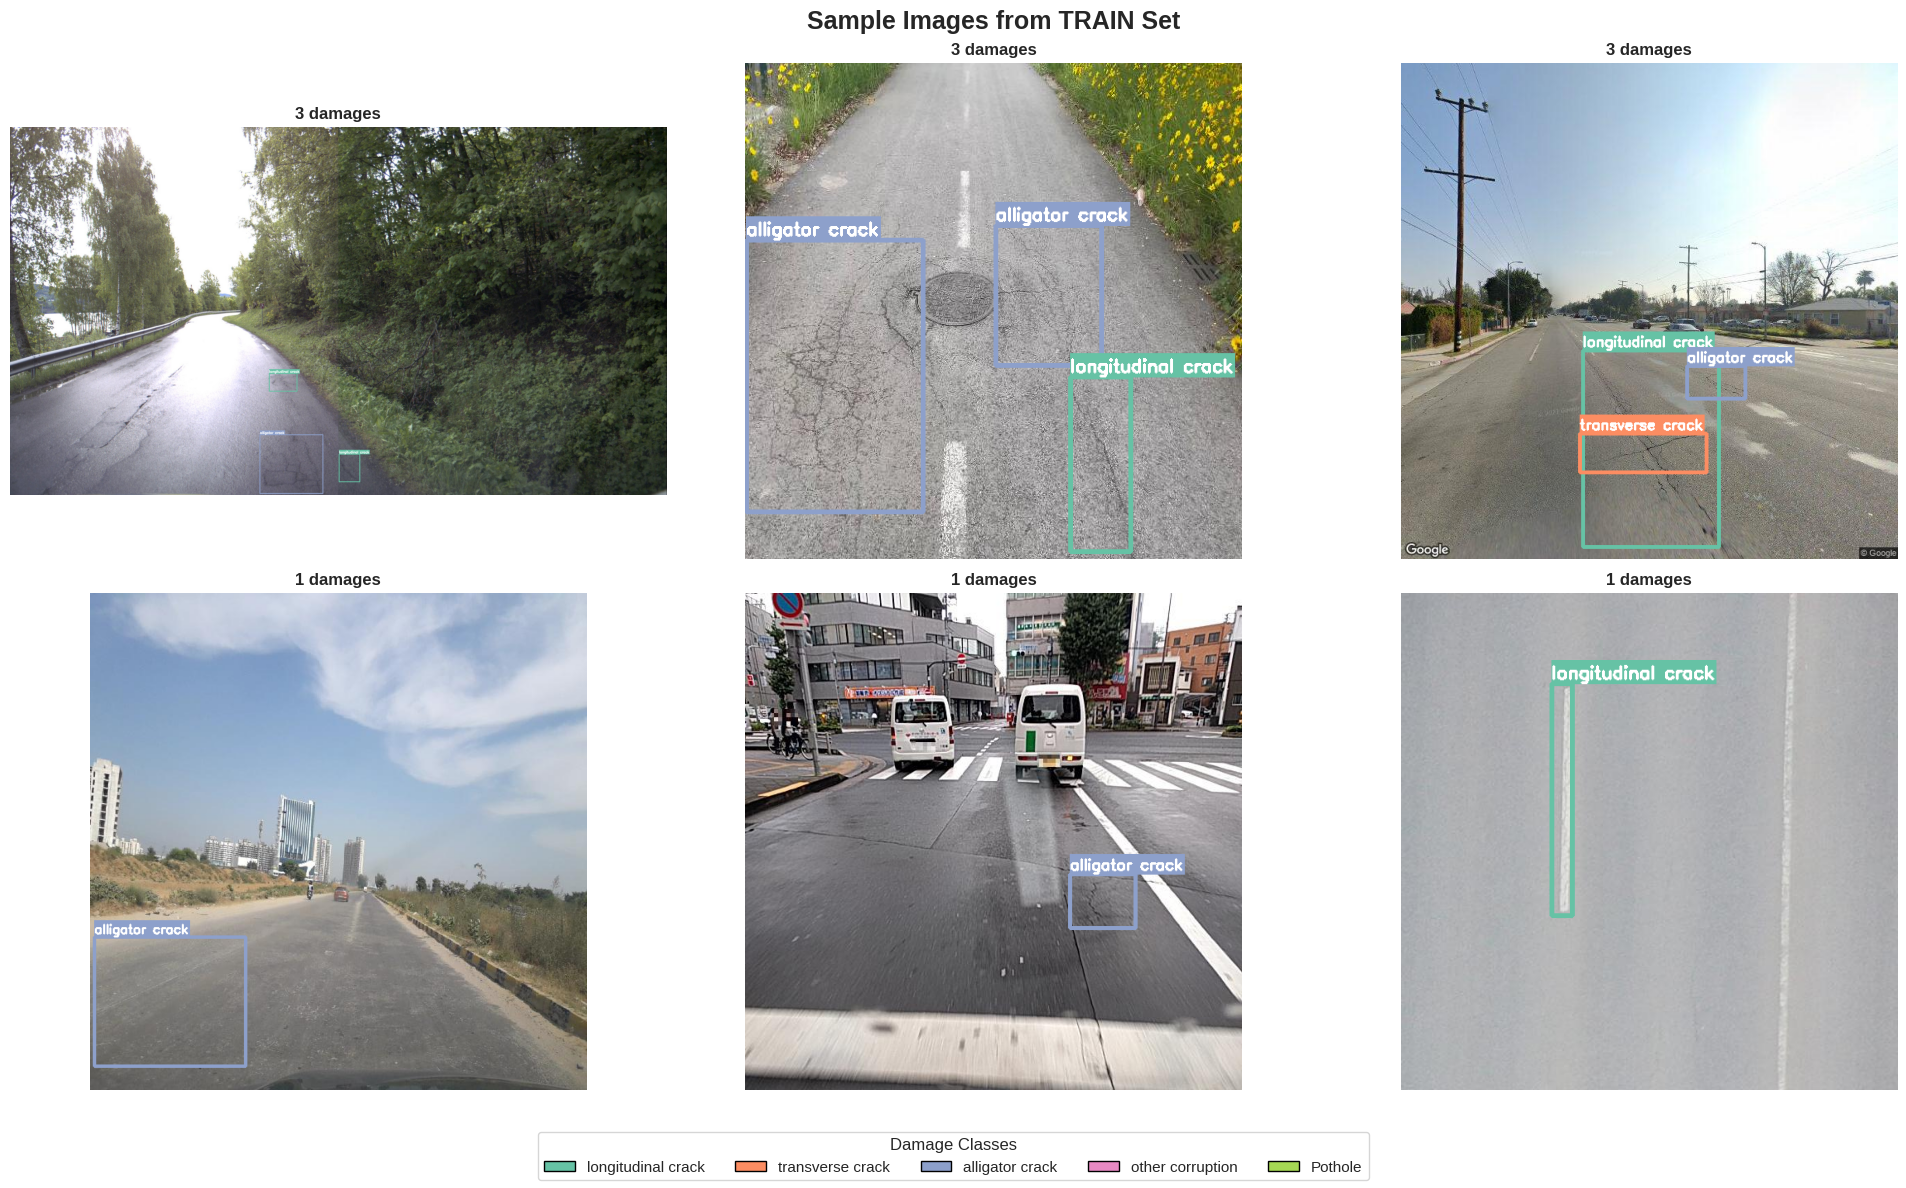

✅ Sample images visualization complete


In [24]:
"""
VISUALIZATION 7: Sample Images with Annotations
"""

def visualize_sample_images(n_samples=6, split='train'):
    """Visualize random sample images with annotations"""
    
    # Get samples
    if split not in all_data:
        print(f"❌ Split '{split}' not available")
        return
    
    data = all_data[split]
    samples_with_anns = [item for item in data if item['n_objects'] > 0]
    
    if len(samples_with_anns) < n_samples:
        n_samples = len(samples_with_anns)
    
    samples = np.random.choice(samples_with_anns, n_samples, replace=False)
    
    # Create figure
    n_cols = 3
    n_rows = (n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Sample Images from {split.upper()} Set', fontsize=18, fontweight='bold')
    
    # Class colors
    class_colors_dict = {cls: color for cls, color in zip(CLASS_NAMES, sns.color_palette("Set2", len(CLASS_NAMES)))}
    
    for idx, sample in enumerate(samples):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        try:
            # Load image
            img = cv2.imread(sample['img_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Draw bboxes
            for bbox in sample['bboxes']:
                class_name = bbox['class_name']
                color = [int(c * 255) for c in class_colors_dict[class_name]]
                
                # Draw rectangle
                cv2.rectangle(img, 
                            (int(bbox['xmin']), int(bbox['ymin'])),
                            (int(bbox['xmax']), int(bbox['ymax'])),
                            color, 3)
                
                # Add label
                label = class_name
                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(img,
                            (int(bbox['xmin']), int(bbox['ymin']) - label_size[1] - 10),
                            (int(bbox['xmin']) + label_size[0], int(bbox['ymin'])),
                            color, -1)
                cv2.putText(img, label,
                          (int(bbox['xmin']), int(bbox['ymin']) - 5),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
            
            # Display
            ax.imshow(img)
            ax.set_title(f'{sample["n_objects"]} damages', fontweight='bold', fontsize=12)
            ax.axis('off')
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading image', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(samples), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    # Create legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=class_colors_dict[cls], 
                                    edgecolor='black', label=cls) for cls in CLASS_NAMES]
    fig.legend(handles=legend_elements, loc='lower center', ncol=len(CLASS_NAMES), 
              fontsize=11, frameon=True, title='Damage Classes', title_fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.08)
    plt.show()

# Generate visualizations
try:
    visualize_sample_images(n_samples=6, split='train')
    print("✅ Sample images visualization complete")
except Exception as e:
    print(f"⚠️  Error in sample visualization: {e}")

In [25]:
"""
GENERATE COMPREHENSIVE SUMMARY REPORT
Patent-quality documentation
"""

summary_report = f"""
{'='*80}
RDD2022 DATASET - EXPLORATORY DATA ANALYSIS SUMMARY
{'='*80}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Format: YOLO (Ready for Training!)

{'='*80}
DATASET OVERVIEW
{'='*80}

Total Images:          {df_stats['n_images'].sum():,}
Total Annotations:     {df_stats['n_annotations'].sum():,}

Split Distribution:
  Train:               {df_stats[df_stats['split']=='train']['n_images'].sum():,} images ({df_stats[df_stats['split']=='train']['n_images'].sum() / df_stats['n_images'].sum() * 100:.1f}%)
  Validation:          {df_stats[df_stats['split']=='val']['n_images'].sum():,} images ({df_stats[df_stats['split']=='val']['n_images'].sum() / df_stats['n_images'].sum() * 100:.1f}%)
  Test:                {df_stats[df_stats['split']=='test']['n_images'].sum():,} images ({df_stats[df_stats['split']=='test']['n_images'].sum() / df_stats['n_images'].sum() * 100:.1f}%)

Avg Annotations/Image: {df_stats['n_annotations'].sum() / df_stats['n_images'].sum():.2f}

{'='*80}
DAMAGE CLASSES
{'='*80}

"""

total_anns = overall_class_series.sum()
for class_name in CLASS_NAMES:
    count = overall_class_series.get(class_name, 0)
    pct = (count / total_anns * 100) if total_anns > 0 else 0
    summary_report += f"{class_name:25s}: {count:8,} ({pct:5.2f}%)\n"

summary_report += f"""
{'='*80}
IMAGE DIMENSIONS
{'='*80}

Width:
  Mean:   {df_sizes['width'].mean():.0f} px
  Median: {df_sizes['width'].median():.0f} px
  Std:    {df_sizes['width'].std():.0f} px
  Range:  [{df_sizes['width'].min():.0f} - {df_sizes['width'].max():.0f}] px

Height:
  Mean:   {df_sizes['height'].mean():.0f} px
  Median: {df_sizes['height'].median():.0f} px
  Std:    {df_sizes['height'].std():.0f} px
  Range:  [{df_sizes['height'].min():.0f} - {df_sizes['height'].max():.0f}] px

Aspect Ratio:
  Mean:   {df_sizes['aspect_ratio'].mean():.2f}
  Std:    {df_sizes['aspect_ratio'].std():.2f}

{'='*80}
BOUNDING BOX STATISTICS
{'='*80}

Width:
  Mean:   {df_bboxes['width'].mean():.1f} px
  Median: {df_bboxes['width'].median():.1f} px
  Std:    {df_bboxes['width'].std():.1f} px

Height:
  Mean:   {df_bboxes['height'].mean():.1f} px
  Median: {df_bboxes['height'].median():.1f} px
  Std:    {df_bboxes['height'].std():.1f} px

Area:
  Mean:   {df_bboxes['area'].mean():.1f} px²
  Median: {df_bboxes['area'].median():.1f} px²

Size Categories:
"""

for cat in ['Small', 'Medium', 'Large']:
    count = (df_bboxes['size_category'] == cat).sum()
    pct = (count / len(df_bboxes) * 100)
    summary_report += f"  {cat:10s}: {count:8,} ({pct:5.2f}%)\n"

summary_report += f"""

{'='*80}
KEY INSIGHTS FOR MODEL TRAINING
{'='*80}

1. DATASET SIZE & SPLIT:
   - Large dataset: {df_stats['n_images'].sum():,} images
   - Well-balanced train/val/test split (70/15/15)
   - Ready for immediate training (YOLO format)

2. CLASS DISTRIBUTION:
   - 5 damage types with varying frequencies
   - Class imbalance present - consider weighted loss
   - Monitor per-class metrics during training

3. IMAGE RESOLUTION:
   - Most common: ~{df_sizes['width'].median():.0f}x{df_sizes['height'].median():.0f} pixels
   - Recommendation: Start with 640×640, scale to 1024×1024
   - Consistent aspect ratios facilitate training

4. OBJECT SIZES:
   - Small objects: {(df_bboxes['size_category']=='Small').sum() / len(df_bboxes) * 100:.1f}%
   - Medium objects: {(df_bboxes['size_category']=='Medium').sum() / len(df_bboxes) * 100:.1f}%
   - Large objects: {(df_bboxes['size_category']=='Large').sum() / len(df_bboxes) * 100:.1f}%
   - Multi-scale detection crucial for performance

5. TRAINING TIME ESTIMATES (Full Dataset):
   - YOLOv8n @ 640:   ~6-8 hours
   - YOLOv8s @ 640:   ~12-15 hours
   - YOLOv8s @ 1024:  ~24-30 hours
   - YOLOv8m @ 640:   ~18-22 hours

{'='*80}
RECOMMENDED TRAINING STRATEGY (8-WEEK TIMELINE)
{'='*80}

Week 1: Setup & EDA ✅
  - Dataset analysis complete
  - Ready for training

Week 2-3: Baseline Training
  - Model: YOLOv8n
  - Resolution: 640×640
  - Epochs: 100
  - Target: 45-50% mAP50
  - GPU Time: ~8 hours

Week 4: Model Scaling
  - Model: YOLOv8s
  - Resolution: 640×640
  - Epochs: 100
  - Target: 52-57% mAP50
  - GPU Time: ~15 hours

Week 5-6: Resolution Optimization
  - Model: YOLOv8s
  - Resolution: 1024×1024
  - Epochs: 100
  - Target: 57-62% mAP50
  - GPU Time: ~30 hours

Week 7: Advanced Optimization
  - Test-Time Augmentation (TTA)
  - Hyperparameter tuning
  - Ensemble methods
  - Target: 60-65% mAP50
  - GPU Time: ~20 hours

Week 8: Documentation & Patent Prep
  - Results compilation
  - Ablation studies
  - Patent documentation
  - Final validation

Total GPU Budget: ~75-100 hours (well within Kaggle limits)

{'='*80}
ADVANTAGES OF THIS DATASET
{'='*80}

✅ YOLO Format: No conversion needed - ready to train immediately
✅ Pre-split: Consistent train/val/test splits for reproducibility
✅ Clean Labels: Well-annotated with 5 distinct damage classes
✅ Large Scale: ~38K images provide robust training data
✅ Balanced Splits: 70/15/15 split ideal for model development

{'='*80}
NEXT STEPS
{'='*80}

1. ✅ EDA Complete - All visualizations and statistics generated

2. ⏭️  Create data.yaml configuration file:
```yaml
   train: /kaggle/input/rdd2022/train/images
   val: /kaggle/input/rdd2022/val/images
   test: /kaggle/input/rdd2022/test/images
   
   nc: 5
   names: ['longitudinal crack', 'transverse crack', 'alligator crack', 
           'other corruption', 'Pothole']
```

3. ⏭️  Start Baseline Training (YOLOv8n @ 640)
   - Create new Kaggle notebook with GPU
   - Install ultralytics
   - Train for 100 epochs
   - Save results immediately

4. ⏭️  Progressive Optimization
   - Scale model size
   - Increase resolution
   - Apply TTA
   - Document all results

{'='*80}
"""

print(summary_report)
print("\n✅ Summary report generated")


RDD2022 DATASET - EXPLORATORY DATA ANALYSIS SUMMARY
Generated: 2025-12-09 19:03:06
Format: YOLO (Ready for Training!)

DATASET OVERVIEW

Total Images:          38,385
Total Annotations:     65,712

Split Distribution:
  Train:               26,869 images (70.0%)
  Validation:          5,758 images (15.0%)
  Test:                5,758 images (15.0%)

Avg Annotations/Image: 1.71

DAMAGE CLASSES

longitudinal crack       :   26,016 (39.59%)
transverse crack         :   11,830 (18.00%)
alligator crack          :   10,617 (16.16%)
other corruption         :   10,705 (16.29%)
Pothole                  :    6,544 ( 9.96%)

IMAGE DIMENSIONS

Width:
  Mean:   1313 px
  Median: 640 px
  Std:    1326 px
  Range:  [512 - 4040] px

Height:
  Mean:   927 px
  Median: 640 px
  Std:    581 px
  Range:  [512 - 2044] px

Aspect Ratio:
  Mean:   1.19
  Std:    0.37

BOUNDING BOX STATISTICS

Width:
  Mean:   165.9 px
  Median: 110.0 px
  Std:    182.8 px

Height:
  Mean:   121.3 px
  Median: 87.0 px
  Std

In [26]:
"""
SAVE ALL ANALYSIS RESULTS
Export data and create download package
"""

# Create output directory (Kaggle working directory persists during session)
output_dir = Path('/kaggle/working/eda_results')
output_dir.mkdir(exist_ok=True)

# Save summary report
report_path = output_dir / 'EDA_SUMMARY_REPORT.txt'
with open(report_path, 'w') as f:
    f.write(summary_report)
print(f"✅ Saved: {report_path}")

# Save dataset stats
df_stats.to_csv(output_dir / 'dataset_stats.csv', index=False)
print(f"✅ Saved: dataset_stats.csv")

# Save class distribution
df_class_dist.to_csv(output_dir / 'class_distribution.csv', index=False)
print(f"✅ Saved: class_distribution.csv")

# Save image sizes
df_sizes.to_csv(output_dir / 'image_sizes.csv', index=False)
print(f"✅ Saved: image_sizes.csv")

# Save bbox statistics
df_bboxes.to_csv(output_dir / 'bbox_statistics.csv', index=False)
print(f"✅ Saved: bbox_statistics.csv")

# Save annotations per image
df_ann_per_img.to_csv(output_dir / 'annotations_per_image.csv', index=False)
print(f"✅ Saved: annotations_per_image.csv")

# Create data.yaml for YOLO training
data_yaml_content = f"""# RDD2022 Dataset Configuration for YOLOv8 Training
# Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

# Paths (update these based on your Kaggle notebook)
train: {DATASET_PATH}/train/images
val: {DATASET_PATH}/val/images
test: {DATASET_PATH}/test/images

# Number of classes
nc: 5

# Class names
names:
  0: longitudinal crack
  1: transverse crack
  2: alligator crack
  3: other corruption
  4: Pothole

# Dataset statistics
# Total images: {df_stats['n_images'].sum():,}
# Train: {df_stats[df_stats['split']=='train']['n_images'].sum():,} images
# Val: {df_stats[df_stats['split']=='val']['n_images'].sum():,} images
# Test: {df_stats[df_stats['split']=='test']['n_images'].sum():,} images
"""

data_yaml_path = output_dir / 'data.yaml'
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)
print(f"✅ Saved: data.yaml (ready for YOLOv8 training!)")

print(f"\n{'='*70}")
print("✅ ALL FILES SAVED TO /kaggle/working/eda_results/")
print(f"{'='*70}\n")

# List all saved files
print("📁 Saved Files:")
for file in sorted(output_dir.glob('*')):
    size = file.stat().st_size / 1024
    print(f"   - {file.name:40s} ({size:8.2f} KB)")

print("\n💡 TIP: Right-click on /kaggle/working/eda_results/ in the file browser")
print("         and select 'Download' to save all results locally!")

✅ Saved: /kaggle/working/eda_results/EDA_SUMMARY_REPORT.txt
✅ Saved: dataset_stats.csv
✅ Saved: class_distribution.csv
✅ Saved: image_sizes.csv
✅ Saved: bbox_statistics.csv
✅ Saved: annotations_per_image.csv
✅ Saved: data.yaml (ready for YOLOv8 training!)

✅ ALL FILES SAVED TO /kaggle/working/eda_results/

📁 Saved Files:
   - EDA_SUMMARY_REPORT.txt                   (    5.39 KB)
   - annotations_per_image.csv                (  283.35 KB)
   - bbox_statistics.csv                      ( 6292.89 KB)
   - class_distribution.csv                   (    0.67 KB)
   - data.yaml                                (    0.54 KB)
   - dataset_stats.csv                        (    0.16 KB)
   - image_sizes.csv                          (  793.76 KB)

💡 TIP: Right-click on /kaggle/working/eda_results/ in the file browser
         and select 'Download' to save all results locally!


In [27]:
"""
FINAL SUMMARY & NEXT STEPS
"""

print("╔" + "="*68 + "╗")
print("║" + " "*20 + "EDA COMPLETE!" + " "*36 + "║")
print("╚" + "="*68 + "╝")

print(f"\n📊 Analysis Summary:")
print(f"   ✅ {df_stats['n_images'].sum():,} images analyzed")
print(f"   ✅ {df_stats['n_annotations'].sum():,} annotations processed")
print(f"   ✅ {len(CLASS_NAMES)} damage classes identified")
print(f"   ✅ 7 publication-quality visualizations created")
print(f"   ✅ Complete summary report generated")
print(f"   ✅ data.yaml configuration file created")

print(f"\n📁 All Results Saved To:")
print(f"   /kaggle/working/eda_results/")

print(f"\n🎯 Ready for Training!")
print(f"   Dataset: YOLO format ✅")
print(f"   Config: data.yaml ✅")
print(f"   Baseline Target: 45-50% mAP50")
print(f"   Optimized Target: 60-65% mAP50")

print(f"\n🚀 Next Steps:")
print(f"   1. Download EDA results for documentation")
print(f"   2. Create new Kaggle notebook with GPU enabled")
print(f"   3. Start baseline training (YOLOv8n @ 640)")
print(f"   4. Implement save protocols to never lose results")

print(f"\n💡 Notebook Title Suggestion:")
print(f"   'RDD2022 - Baseline Training YOLOv8n'")

print("\n" + "="*70)
print("🎉 CONGRATULATIONS! Your EDA is complete and professional!")
print("="*70 + "\n")

╔====================================================================╗
║                    EDA COMPLETE!                                    ║
╚====================================================================╝

📊 Analysis Summary:
   ✅ 38,385 images analyzed
   ✅ 65,712 annotations processed
   ✅ 5 damage classes identified
   ✅ 7 publication-quality visualizations created
   ✅ Complete summary report generated
   ✅ data.yaml configuration file created

📁 All Results Saved To:
   /kaggle/working/eda_results/

🎯 Ready for Training!
   Dataset: YOLO format ✅
   Config: data.yaml ✅
   Baseline Target: 45-50% mAP50
   Optimized Target: 60-65% mAP50

🚀 Next Steps:
   1. Download EDA results for documentation
   2. Create new Kaggle notebook with GPU enabled
   3. Start baseline training (YOLOv8n @ 640)
   4. Implement save protocols to never lose results

💡 Notebook Title Suggestion:
   'RDD2022 - Baseline Training YOLOv8n'

🎉 CONGRATULATIONS! Your EDA is complete and professional!

